In [2]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import csv  

sns.set_style('whitegrid')
%matplotlib inline



from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder





In [57]:
# crawl the data from the website 


# puuid 
# puuid = "CUcPTA2mHGm2O_wFyZl0p5pC4s2OV-uXAt7cnyuK_ylHZNWuHji609Zv6dyvBKU4BuKJ1S1tIru4GA"
puuid = 'l29aAZyYOOHEX6oeQFvbuIE_bKtVVwZgwv27g0fDb9_zad8K1gr0v3p6CcI8KkxdV7mHlaj2Yrb8UA'

# Chỉ số trận đấu đầu tiên và cuối cùng trong danh sách
begin_indedf = 0
end_indedf = 100

# API key của bạn(riot chỉ cho hạn hơn 1 ngày nên khi dùng cần làm mới key)
api_key = "RGAPI-cb5f6138-d6ef-4dc5-acfd-29017b450b12"


# Tạo đường dẫn truy vấn API lấy danh sách match id
requestUrl_for_matchIds = f"https://sea.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?type=ranked&start={begin_indedf}&count={end_indedf}&api_key={api_key}"

# Gửi truy vấn API và phân tích phản hồi JSON
responseMatchId = requests.get(requestUrl_for_matchIds)
matchIds = json.loads(responseMatchId.text)

listInfo = []


keys_to_delete = ["challenges","perks","puuid","summonerId","riotIdName","riotIdTagline",'profileIcon', 'championTransform',
                   'participantId', 'spell1Casts', 'spell2Casts', 'spell3Casts' ,'spell4Casts', 'summoner1Casts', 'summoner2Casts', 
                   'summoner1Id', 'summoner2Id', 'summonerName', 'teamId', 'unrealKills', 'playerAugment1', 'playerAugment2', 'playerAugment3', 'playerAugment4',
       'playerSubteamId', 'subteamPlacement', 'eligibleForProgression','individualPosition','lane','role', 'item0', 'item1', 'item2', 'item3', 'item4','item5','item6'
       , 'itemsPurchased', 'damageDealtToTurrets', 'gameEndedInEarlySurrender', 'gameEndedInSurrender']

# Gửi truy vấn API lấy thông tin của từng match
for matchId in matchIds :
    requestUrl_for_matchInfor_byId = f"https://sea.api.riotgames.com/lol/match/v5/matches/{matchId}?api_key={api_key}"
    respondMatch = requests.get(requestUrl_for_matchInfor_byId)
    data = json.loads(respondMatch.text)
    # print(data.keys())
    if "info" in data: 
        dataPar = data["info"]["participants"] 
        # print(len(dataPar))
        for par in dataPar:
            par_copy = par.copy()  
            for key in keys_to_delete:
                par_copy.pop(key, None)
            listInfo.append(par_copy)





In [60]:
# crawl the data from the website 


# puuid 
puuid = "CUcPTA2mHGm2O_wFyZl0p5pC4s2OV-uXAt7cnyuK_ylHZNWuHji609Zv6dyvBKU4BuKJ1S1tIru4GA"
# puuid = 'l29aAZyYOOHEX6oeQFvbuIE_bKtVVwZgwv27g0fDb9_zad8K1gr0v3p6CcI8KkxdV7mHlaj2Yrb8UA'

matchIds = [
        "VN2_83275064",
        "VN2_82721932",
        "VN2_78542765",
        "VN2_77232896",
        "VN2_77217025",
        "VN2_77181141",
        "VN2_77163010",
        "VN2_73401164",
        "VN2_71964639",
        "VN2_71945440",
        "VN2_71914817",
        "VN2_71862963",
        "VN2_71851932",
        "VN2_71361725",
        "VN2_71326636",
        "VN2_71314028",
        "VN2_71257489",
        "VN2_71232053",
        "VN2_71200151",
        "VN2_71174032",
        "VN2_70566038",
        "VN2_70527865",
        "VN2_70506266",
        "VN2_70476527",
        "VN2_70443567",
        "VN2_70422403",
        "VN2_70389565",
        "VN2_70369906",
        "VN2_70348868",
        "VN2_69708685",
        "VN2_69684553",
        "VN2_69490935",
        "VN2_69487656",
        "VN2_69492088",
        "VN2_68984354",
        "VN2_68952635",
        "VN2_68740887",
        "VN2_68229209",
        "VN2_68194576",
        "VN2_68170910",
        "VN2_67586436",
        "VN2_67566382",
        "VN2_67552317",
        "VN2_67478044",
        "VN2_67450148",
        "VN2_66876022",
        "VN2_66844555",
        "VN2_66815874",
        "VN2_66739257",
        "VN2_66675623",
        "VN2_66675436",
        "VN2_66445969",
        "VN2_66347150",
        "VN2_66235592",
        "VN2_66207385",
        "VN2_66171230",
        "VN2_65899736",
        "VN2_65900093",
        "VN2_65881763",
        "VN2_65874782",
        "VN2_65862856",
        "VN2_65607671",
        "VN2_65581435",
        "VN2_65554140",
        "VN2_65454238",
        "VN2_65429413",
        "VN2_65110772",
        "VN2_64918173",
        "VN2_64867863",
        "VN2_64631338",
        "VN2_64615301",
        "VN2_64584327",
        "VN2_64249984",
        "VN2_64222309",
        "VN2_64111268",
        "VN2_63679831",
        "VN2_63675422",
        "VN2_63659899",
        "VN2_63654367",
        "VN2_63646333",
        "VN2_63627212",
        "VN2_63615886",
        "VN2_63605145",
        "VN2_63343151",
        "VN2_63328276",
        "VN2_63289532",
        "VN2_63273409",
        "VN2_63237963",
        "VN2_63226095",
        "VN2_63130015",
        "VN2_62279893",
        "VN2_61572767",
        "VN2_61051987",
        "VN2_60292052",
        "VN2_59970811",
        "VN2_59677318",
        "VN2_59203635",
        "VN2_59196797",
        "VN2_58760619",
        "VN2_58462558"
    ]


keys_to_delete = ["challenges","perks","puuid","summonerId","riotIdName","riotIdTagline",'profileIcon', 'championTransform',
                   'participantId', 'spell1Casts', 'spell2Casts', 'spell3Casts' ,'spell4Casts', 'summoner1Casts', 'summoner2Casts', 
                   'summoner1Id', 'summoner2Id', 'summonerName', 'teamId', 'unrealKills', 'playerAugment1', 'playerAugment2', 'playerAugment3', 'playerAugment4',
       'playerSubteamId', 'subteamPlacement', 'eligibleForProgression','individualPosition','lane','role', 'item0', 'item1', 'item2', 'item3', 'item4','item5','item6'
       , 'itemsPurchased', 'damageDealtToTurrets', 'gameEndedInEarlySurrender', 'gameEndedInSurrender']

# Gửi truy vấn API lấy thông tin của từng match
for matchId in matchIds :
    requestUrl_for_matchInfor_byId = f"https://sea.api.riotgames.com/lol/match/v5/matches/{matchId}?api_key={api_key}"
    respondMatch = requests.get(requestUrl_for_matchInfor_byId)
    data = json.loads(respondMatch.text)
    # print(data.keys())
    if "info" in data: 
        dataPar = data["info"]["participants"] 
        # print(len(dataPar))
        for par in dataPar:
            par_copy = par.copy()  
            for key in keys_to_delete:
                par_copy.pop(key, None)
            listInfo.append(par_copy)





In [61]:
len(listInfo)

1980

In [62]:
# write data to file
def array_to_csv(data_array, filename):
    keys = data_array[0].keys()  # Lấy danh sách các khóa từ đối tượng đầu tiên trong mảng
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=keys)
        writer.writeheader()  # Viết header với các khóa làm cột
        for obj in data_array:
            writer.writerow(obj)
array_to_csv(listInfo, '../data_governance/data.csv')


In [63]:
df = pd.read_csv('data.csv')

In [64]:
df.shape

(1980, 88)

In [65]:
df.head()

,allInPings,assistMePings,assists,baitPings,baronKills,basicPings,bountyLevel,champExperience,champLevel,championId,...,trueDamageTaken,turretKills,turretTakedowns,turretsLost,visionClearedPings,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win
0,1,2,6,0,0,0,0,20186,18,24,...,1103,2,2,3,0,28,1,4,10,True
1,0,0,12,0,2,0,0,18355,17,234,...,4557,3,3,3,0,25,3,8,1,True
2,0,0,7,0,0,0,3,20530,18,1,...,1445,1,6,3,0,18,0,2,9,True
3,0,0,6,0,0,0,1,16072,16,222,...,699,2,4,3,0,21,0,2,10,True
4,0,5,10,0,0,0,1,13444,15,12,...,2798,1,3,3,1,77,1,10,25,True


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 88 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   allInPings                      1980 non-null   int64  
 1   assistMePings                   1980 non-null   int64  
 2   assists                         1980 non-null   int64  
 3   baitPings                       1980 non-null   int64  
 4   baronKills                      1980 non-null   int64  
 5   basicPings                      1980 non-null   int64  
 6   bountyLevel                     1980 non-null   int64  
 7   champExperience                 1980 non-null   int64  
 8   champLevel                      1980 non-null   int64  
 9   championId                      1980 non-null   int64  
 10  championName                    1980 non-null   object 
 11  commandPings                    1980 non-null   int64  
 12  consumablesPurchased            19

In [67]:
def check_missing(df):
    # Check if the feature missing values 
    columns_with_missing_values_bool = df.select_dtypes(include=bool).columns[df.select_dtypes(include=bool).isna().any()]
    columns_with_missing_values_float = df.select_dtypes(include=float).columns[df.select_dtypes(include=float).isna().any()]
    columns_with_missing_values_int = df.select_dtypes(include=int).columns[df.select_dtypes(include=int).isna().any()]
    columns_with_missing_values_object = df.select_dtypes(include=object).columns[df.select_dtypes(include=object).isna().any()]

    # print column names that are missing
    print("Các cột bool có dữ liệu trống:", columns_with_missing_values_bool)
    print("Các cột float có dữ liệu trống:", columns_with_missing_values_float)
    print("Các cột int có dữ liệu trống:", columns_with_missing_values_int)
    print("Các cột object có dữ liệu trống:", columns_with_missing_values_object)

In [68]:
# Check duplicates
duplicates = df.duplicated()
dup = duplicates.sum()
dup

20

In [69]:

def select_types(x, type):
    return x.select_dtypes(include=type)
object_columns = select_types(df,'object')
bool_columns = select_types(df, 'bool')
float_columns = select_types(df, 'float')
int_colmns = select_types(df, 'int')


In [70]:
# split the data into groups by position 
top_df = df[df['teamPosition']=='TOP']
jg_df = df[df['teamPosition']=='JUNGLE']
mid_df = df[df['teamPosition']=='MIDDLE']
bot_df = df[df['teamPosition']=='BOTTOM']
sp_df = df[df['teamPosition']=='UTILITY']



In [71]:
# check and fill missing values if exist
# check_missing(top_df)
# check_missing(jg_df)
# check_missing(mid_df)
# check_missing(bot_df)
# check_missing(sp_df)

#fill missing columns top df with mode
top_df['totalAllyJungleMinionsKilled'].value_counts()
top_df['totalAllyJungleMinionsKilled'].fillna(0)
top_df['totalEnemyJungleMinionsKilled'].fillna(0)
#fill missing columns mid df with mode
mid_df['totalAllyJungleMinionsKilled'].value_counts()
mid_df['totalAllyJungleMinionsKilled'].fillna(0)
mid_df['totalEnemyJungleMinionsKilled'].fillna(0)

#fill missing columns bot df with mode
bot_df['totalAllyJungleMinionsKilled'].value_counts()
bot_df['totalAllyJungleMinionsKilled'].fillna(0)
bot_df['totalEnemyJungleMinionsKilled'].fillna(0)

#fill missing columns sp df with mode
sp_df['totalAllyJungleMinionsKilled'].value_counts()
sp_df['totalAllyJungleMinionsKilled'].fillna(0)
sp_df['totalEnemyJungleMinionsKilled'].fillna(0)

#fill missing columns jg df
jg_df['totalAllyJungleMinionsKilled'].value_counts()
jg_df['totalAllyJungleMinionsKilled'].fillna(value=jg_df['totalAllyJungleMinionsKilled'].median(), inplace=True)
jg_df['totalEnemyJungleMinionsKilled'].fillna(value=jg_df['totalEnemyJungleMinionsKilled'].median(), inplace=True)


C:\Users\anhda\AppData\Local\Temp\ipykernel_19292\3986462738.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jg_df['totalAllyJungleMinionsKilled'].fillna(value=jg_df['totalAllyJungleMinionsKilled'].median(), inplace=True)
C:\Users\anhda\AppData\Local\Temp\ipykernel_19292\3986462738.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jg_df['totalEnemyJungleMinionsKilled'].fillna(value=jg_df['totalEnemyJungleMinionsKilled'].median(), inplace=True)


In [72]:
# most chapions picked up 
def plot_chapions(df):   
    df['championName'].value_counts().plot(kind='bar', figsize=(14,6))
    plt.show()
 

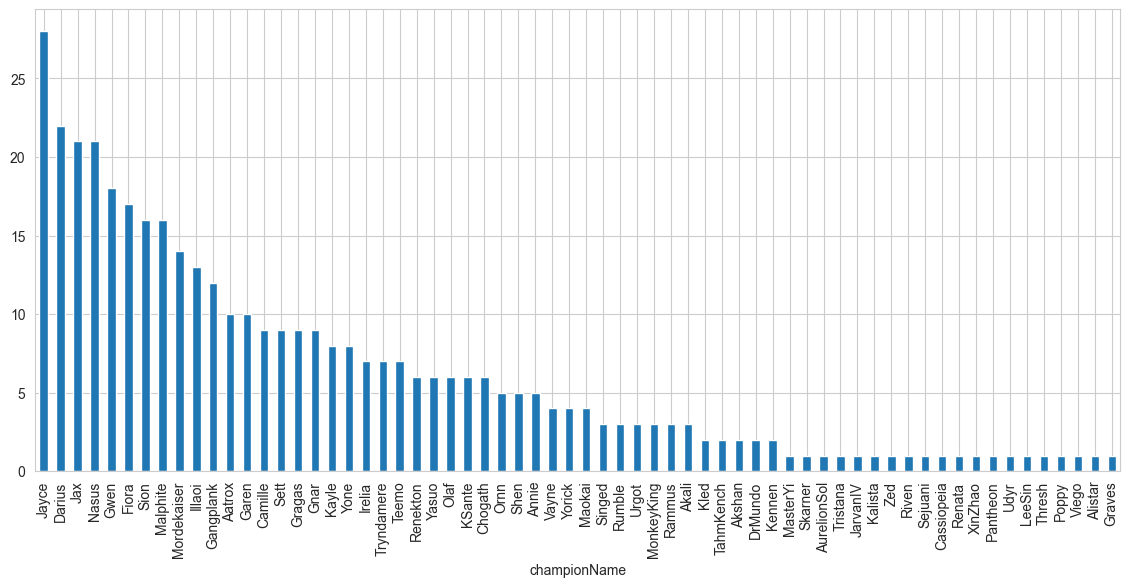

In [73]:
plot_chapions(top_df)


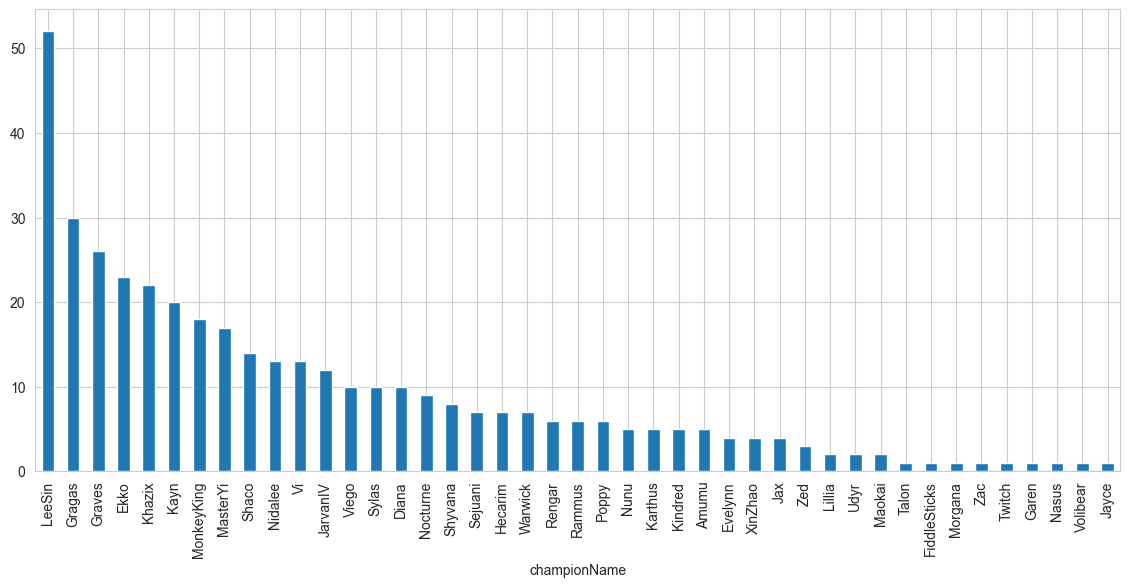

In [74]:
plot_chapions(jg_df)

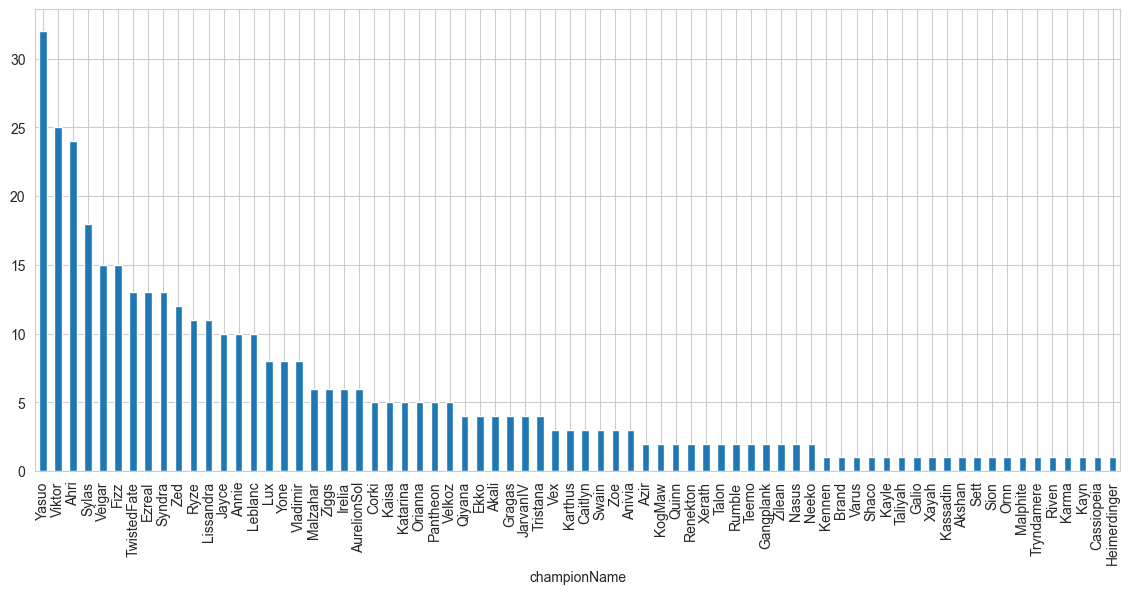

In [75]:
plot_chapions(mid_df)

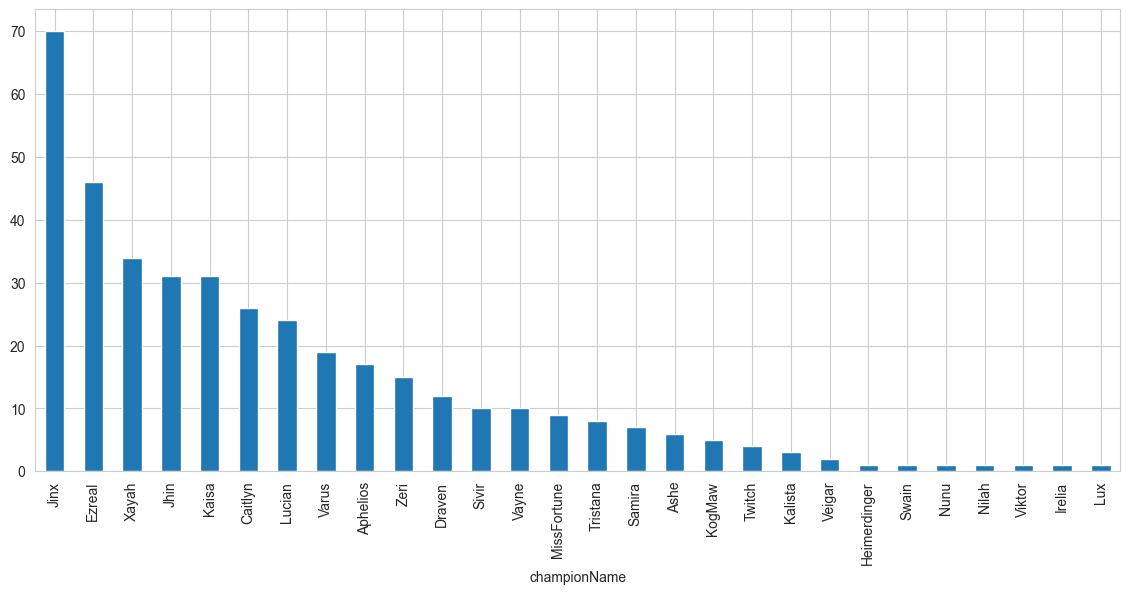

In [76]:
plot_chapions(bot_df)

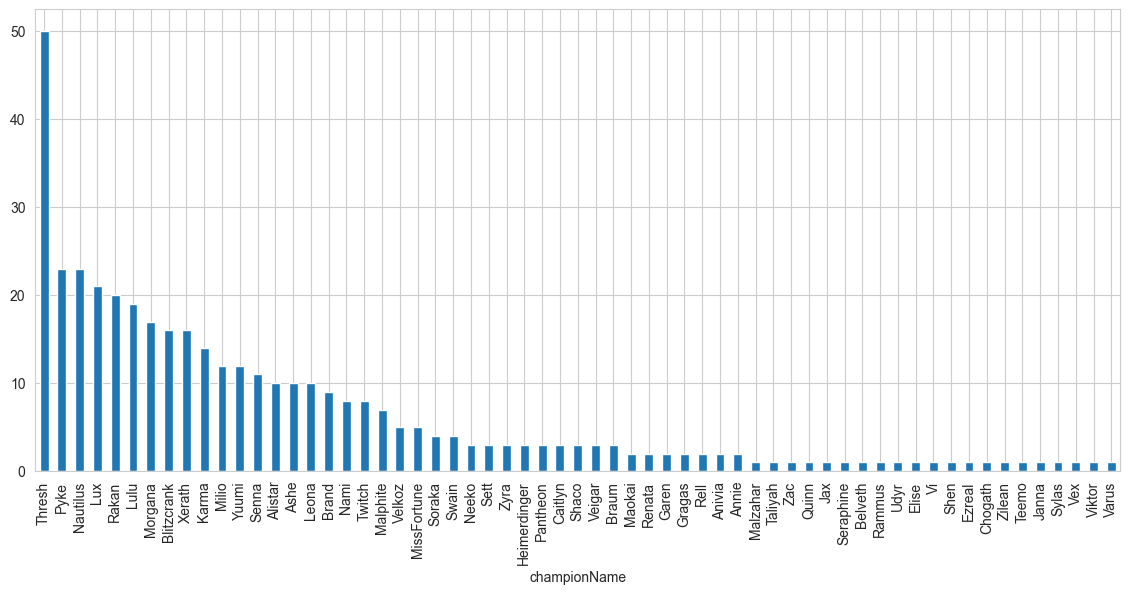

In [77]:
plot_chapions(sp_df)

In [78]:
# Champions win rates
def plot_champion_win_rates(df):
    champ_arr = df['championName'].value_counts().index
    win_rates = [] 
    for champ in champ_arr:
        win_rate = df.loc[(df['championName']==champ) &(df['win']==True)].shape[0]*100/df.loc[(df['championName']==champ)].shape[0]
        win_rates += [win_rate]
    fig = plt.figure(figsize=(14,6))
    plt.bar(champ_arr, win_rates)
    plt.xlabel('Champions')
    plt.ylabel('Win rates')
    plt.title('win rates of selected champions')
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.2)
    plt.show()


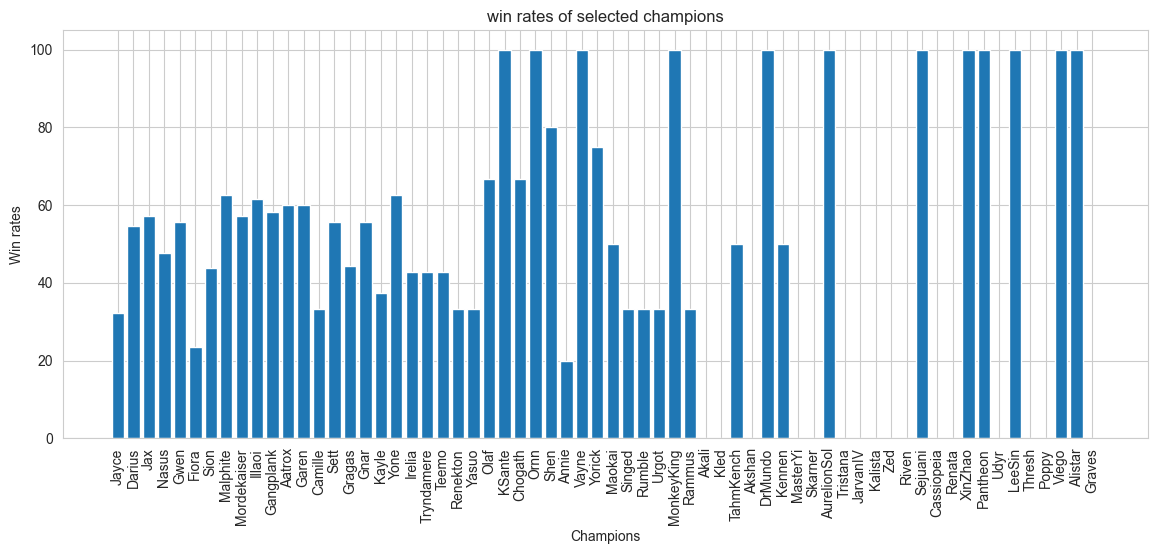

In [79]:
plot_champion_win_rates(top_df)

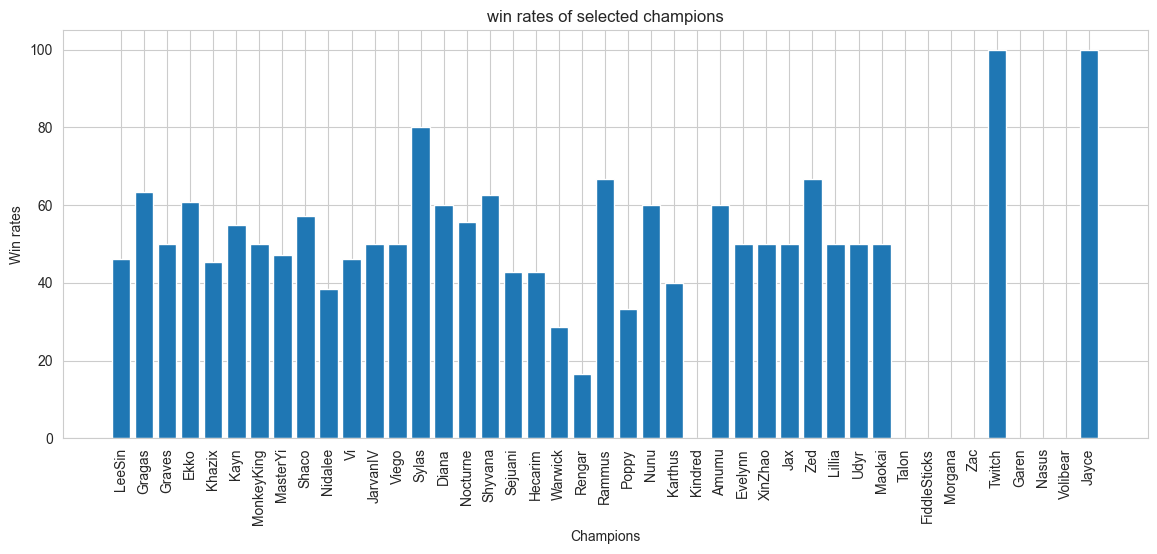

In [80]:
plot_champion_win_rates(jg_df)

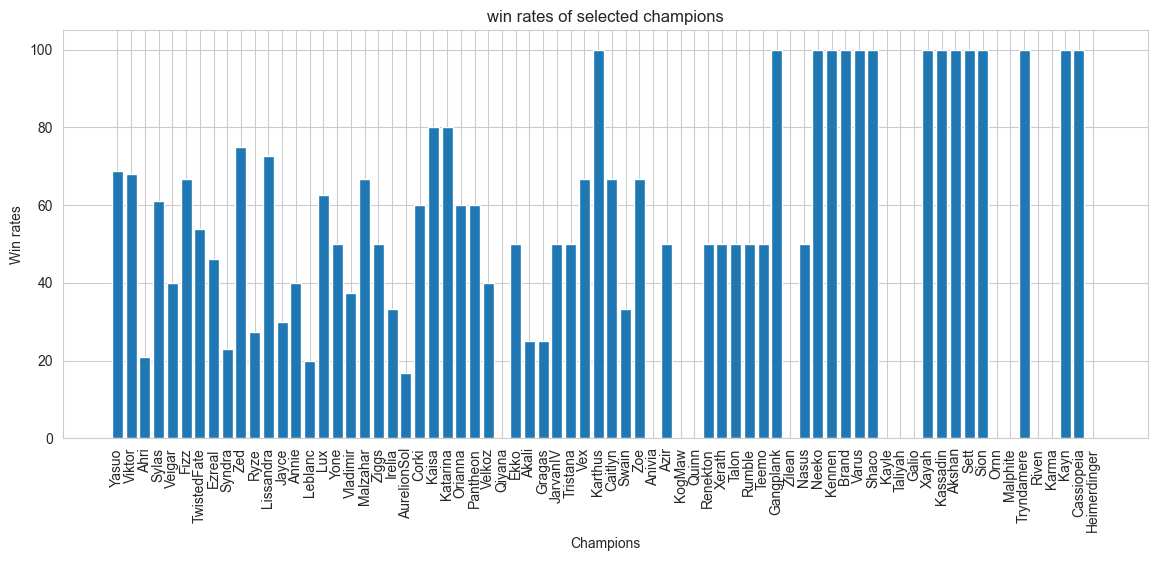

In [81]:
plot_champion_win_rates(mid_df)

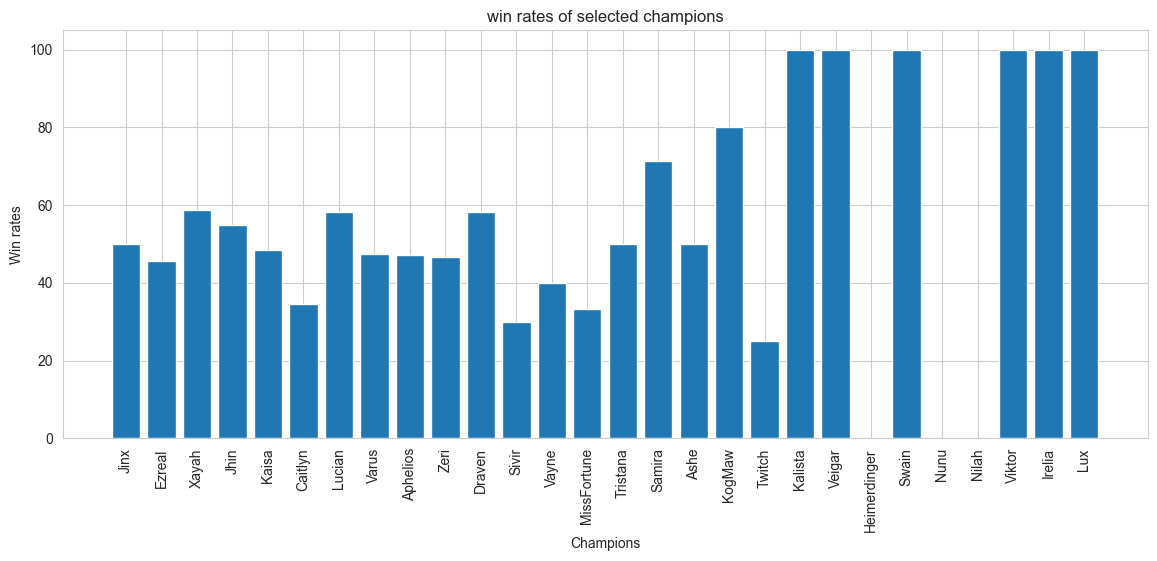

In [82]:
plot_champion_win_rates(bot_df)

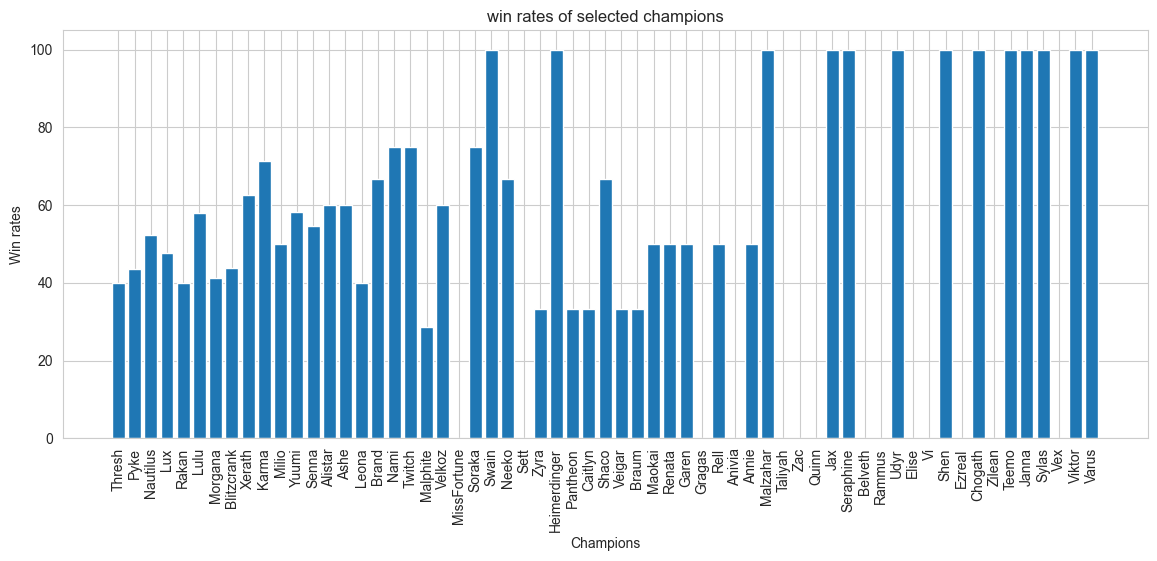

In [83]:
plot_champion_win_rates(sp_df)

In [84]:
# visualize kda of each position
def visualize_kda(df):
    kda_col= ['kills', 'deaths', 'assists']
    sum_lose = df.loc[df['win']==False,kda_col].sum(axis=0)
    sum_win = df.loc[df['win']==True,kda_col].sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    ax.bar(np.arange(len(sum_lose)), sum_lose, width=0.3, color='red', label='lose')
    ax.bar(np.arange(len(sum_win)) + 0.3, sum_win, width=0.3, color='blue', label='win')
    ax.set_xticks(np.arange(len(sum_lose)) + 0.3/2)
    ax.set_xticklabels(sum_lose.index)
    ax.set_ylabel('kda')
    ax.legend()
    plt.show()

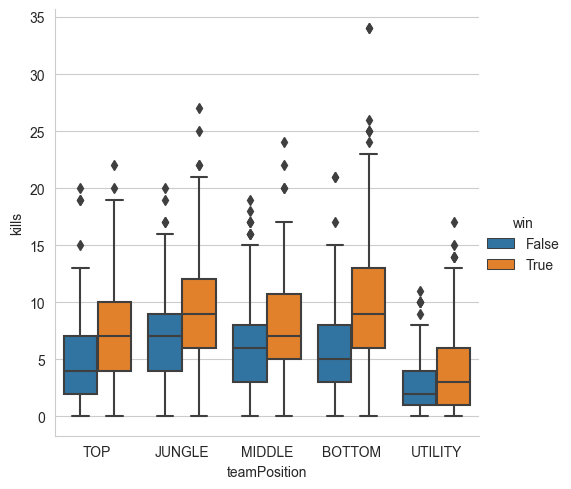

In [85]:
# With seaborn
sns.catplot(data=df, x='teamPosition', y='kills', hue='win', kind='box')

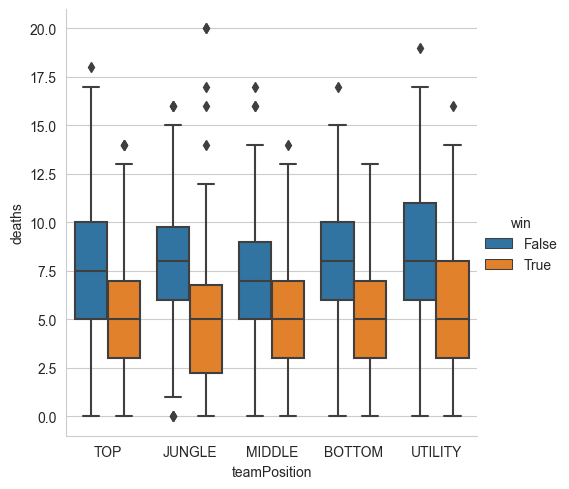

In [86]:
sns.catplot(data=df, x='teamPosition', y='deaths', hue='win', kind='box')

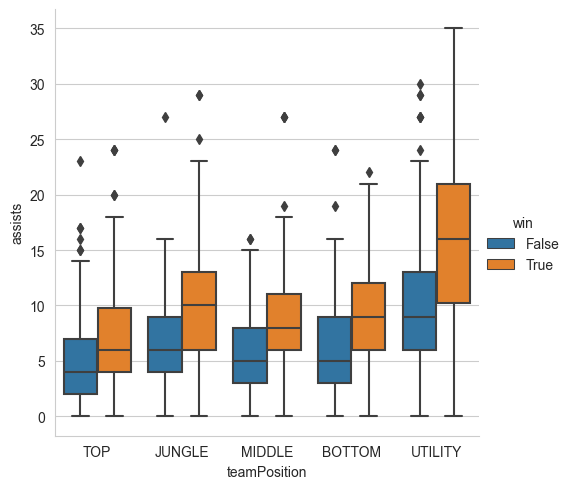

In [87]:
sns.catplot(data=df, x='teamPosition', y='assists', hue='win', kind='box')

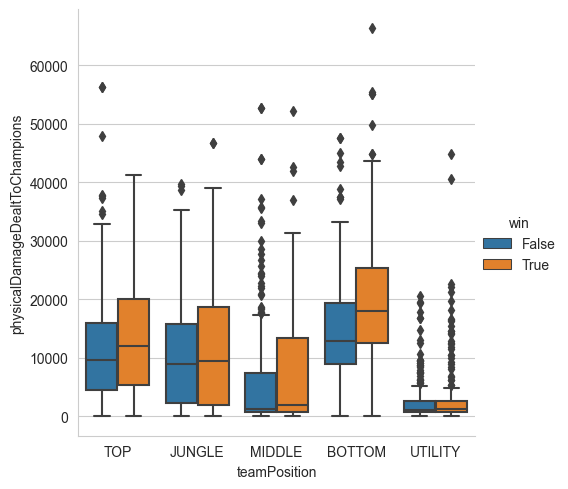

In [88]:
sns.catplot(data=df, x='teamPosition', y='physicalDamageDealtToChampions', hue='win', kind='box')


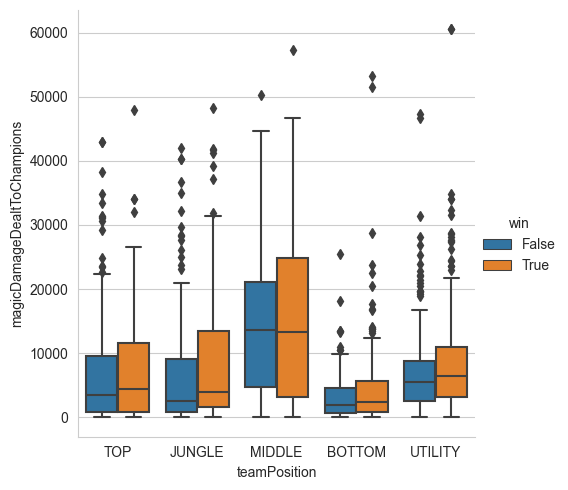

In [89]:
sns.catplot(data=df, x='teamPosition', y='magicDamageDealtToChampions', hue='win', kind='box')


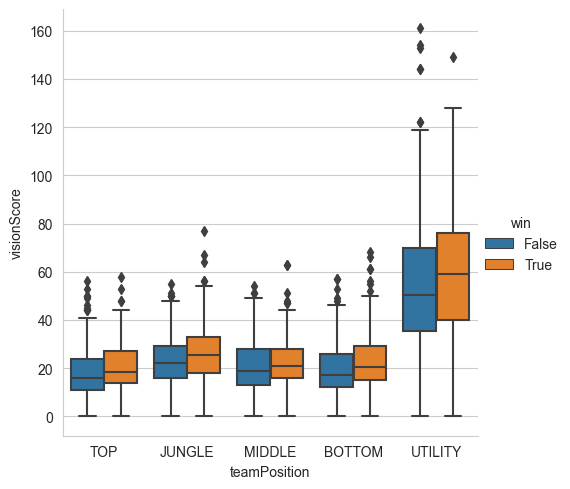

In [120]:
sns.catplot(data=df, x='teamPosition', y='visionScore', hue='win', kind='box')

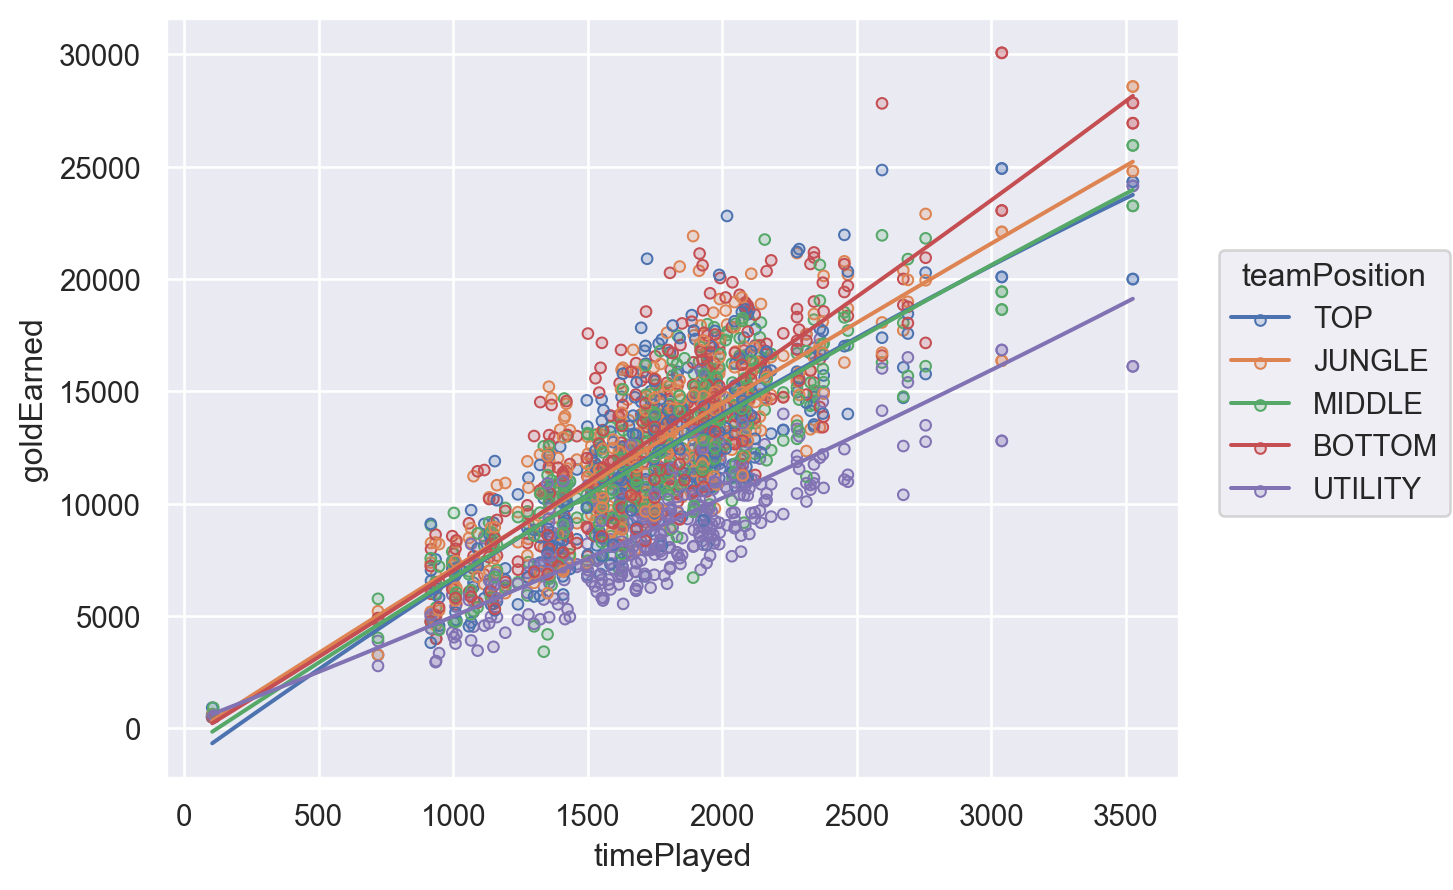

In [90]:
# goldEarned over time
(so.Plot(df, x='timePlayed', y='goldEarned', color='teamPosition')
 .add(so.Dots())
 .add(so.Line(), so.PolyFit())
)


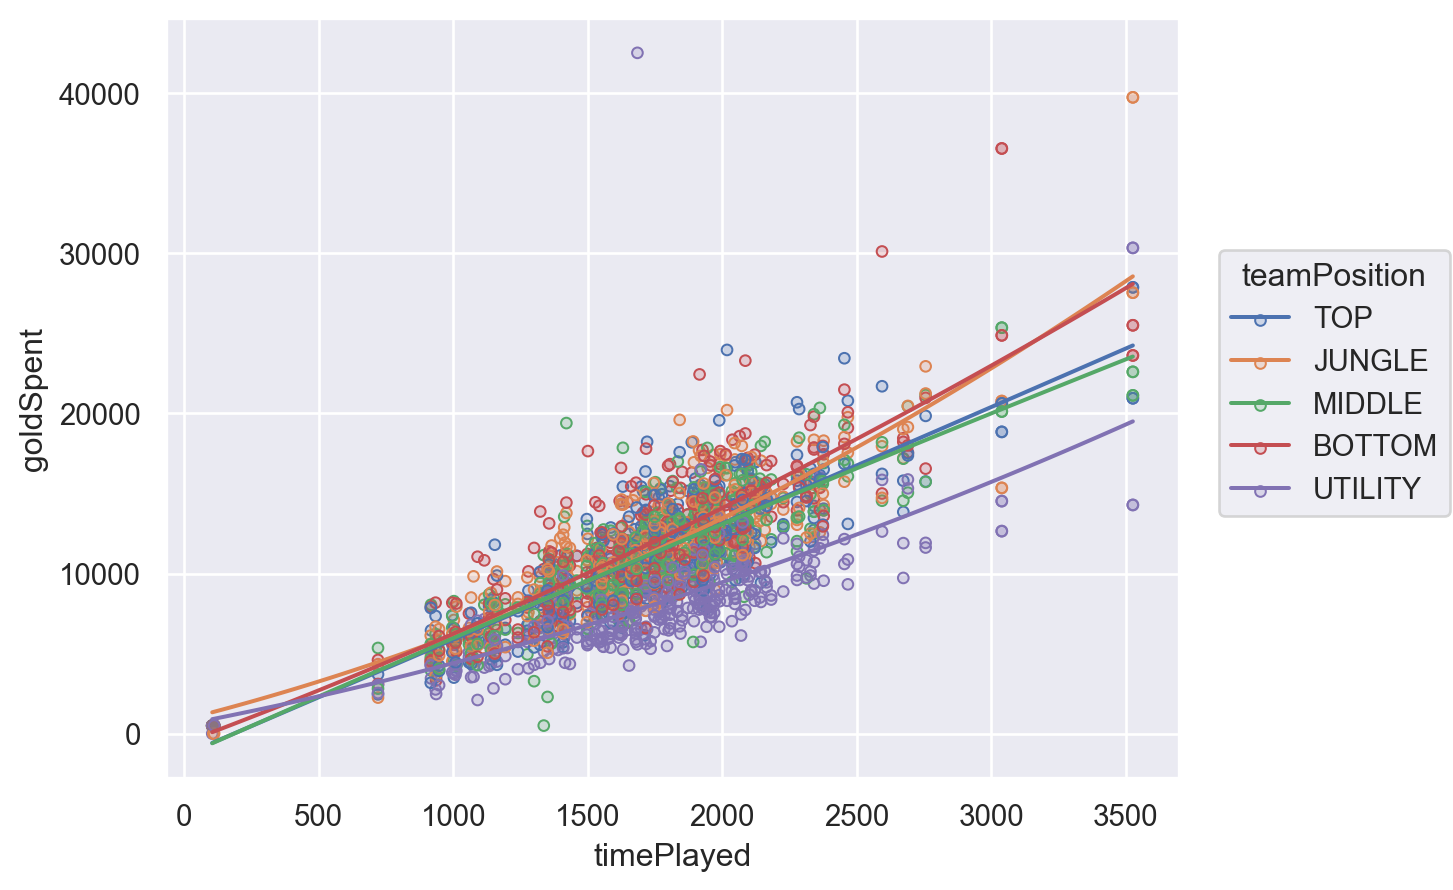

In [91]:
# goldSpent over time
(so.Plot(df, x='timePlayed', y='goldSpent', color='teamPosition')
 .add(so.Dots())
 .add(so.Line(), so.PolyFit())
)

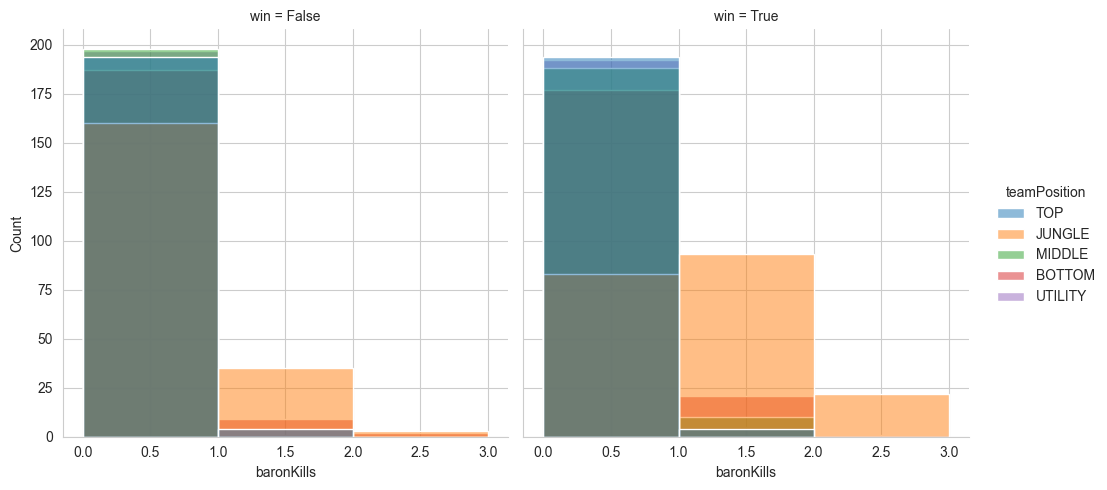

In [92]:
sns.displot(df, x='baronKills', hue='teamPosition', col='win', bins=3)

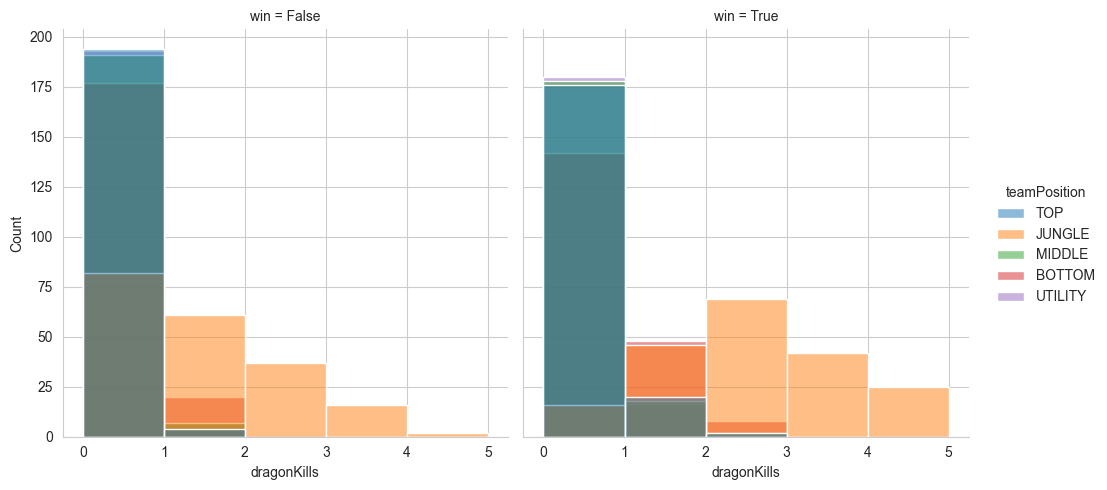

In [93]:
sns.displot(df, x='dragonKills', hue='teamPosition', col='win', bins=5)

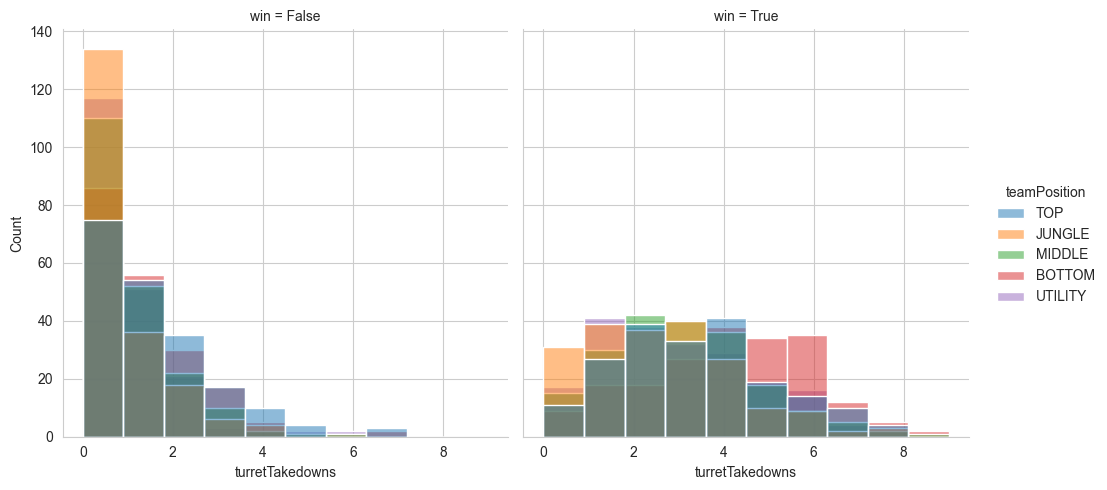

In [94]:
sns.displot(df, x='turretTakedowns', hue='teamPosition', col='win', bins=10)


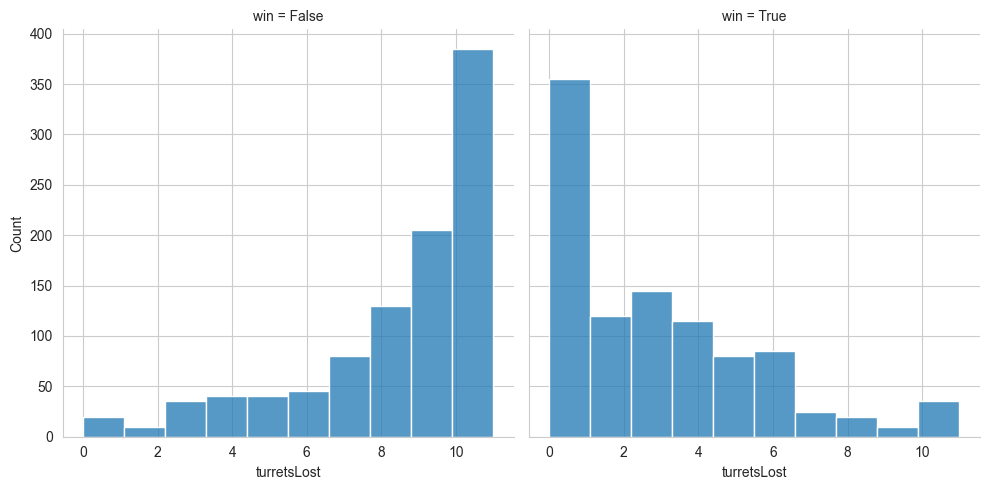

In [95]:
sns.displot(df, x='turretsLost', col='win', bins=10)


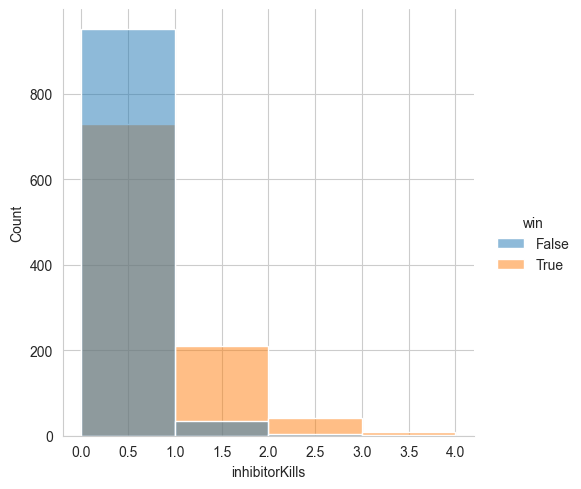

In [96]:
sns.displot(df, x='inhibitorKills', hue='win', bins=4)

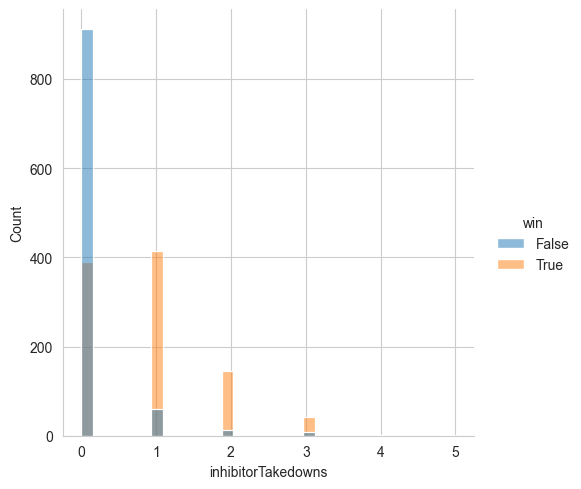

In [97]:
sns.displot(df, x='inhibitorTakedowns', hue='win')

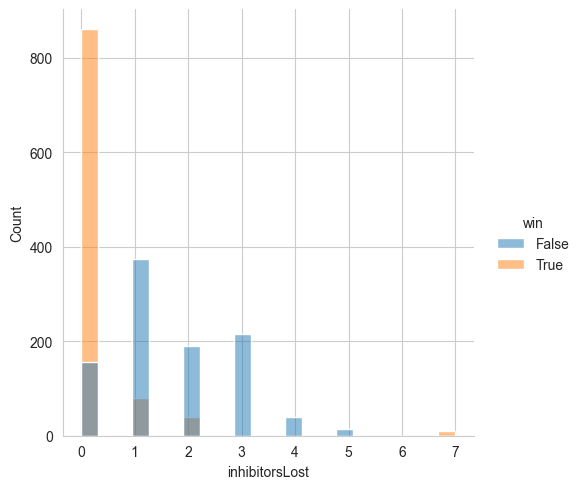

In [98]:
sns.displot(df, x='inhibitorsLost', hue='win')

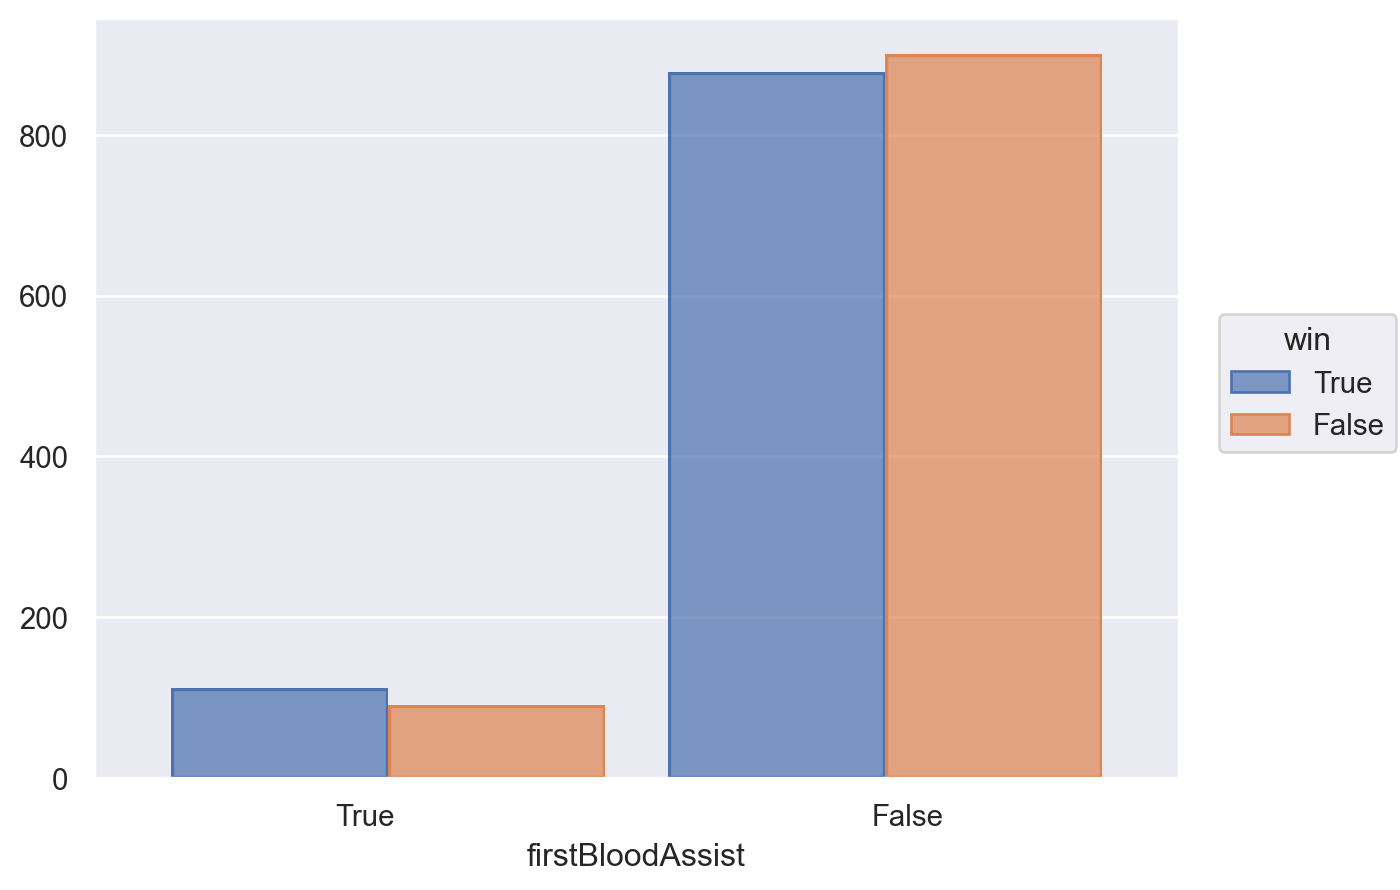

In [102]:
(
    so.Plot(df, x="firstBloodAssist", color='win')
    .add(so.Bar(), so.Hist(), so.Dodge())
)

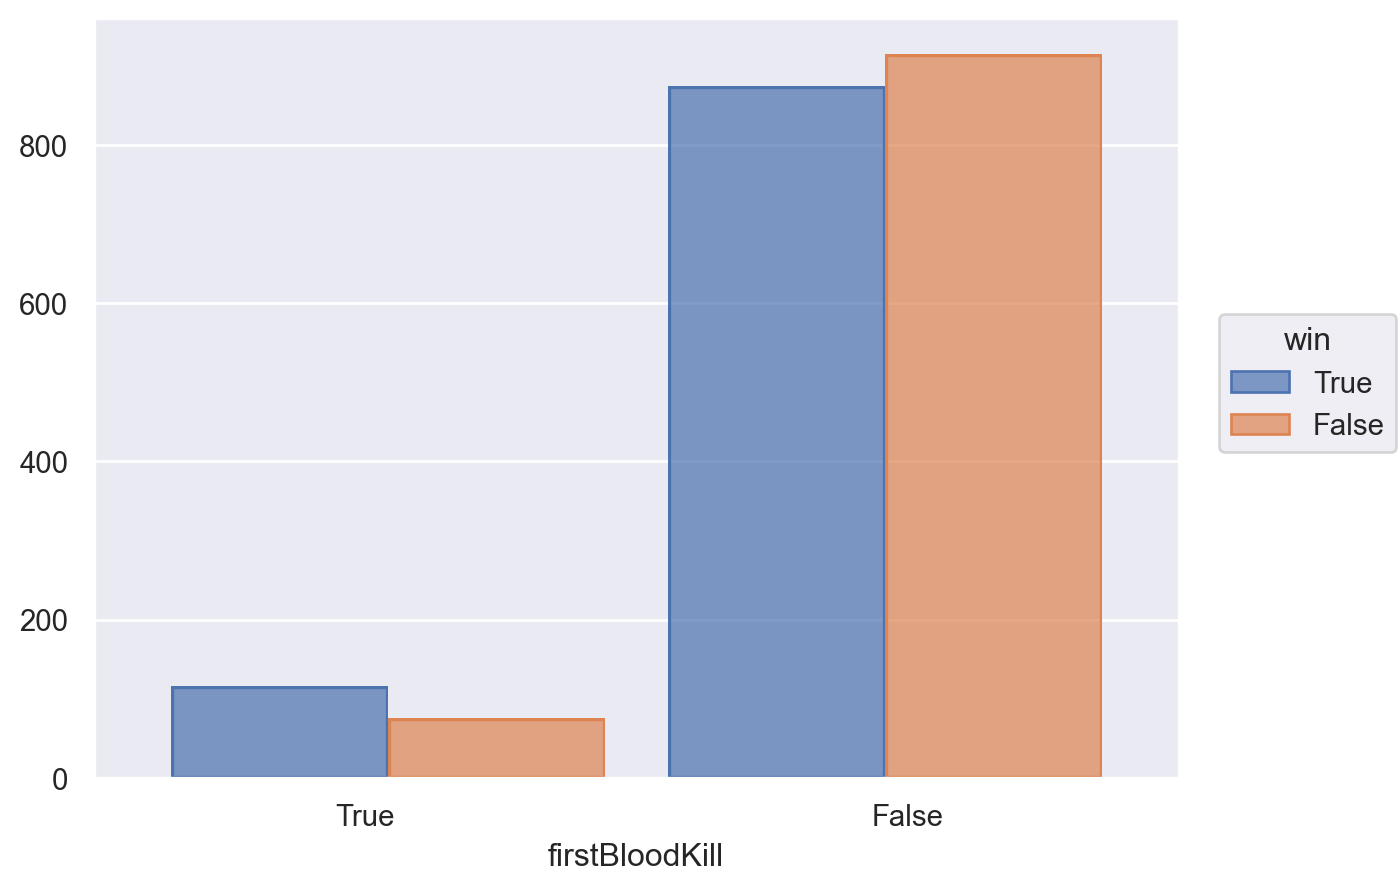

In [103]:
(
    so.Plot(df, x="firstBloodKill", color='win')
    .add(so.Bar(), so.Hist(), so.Dodge())
)

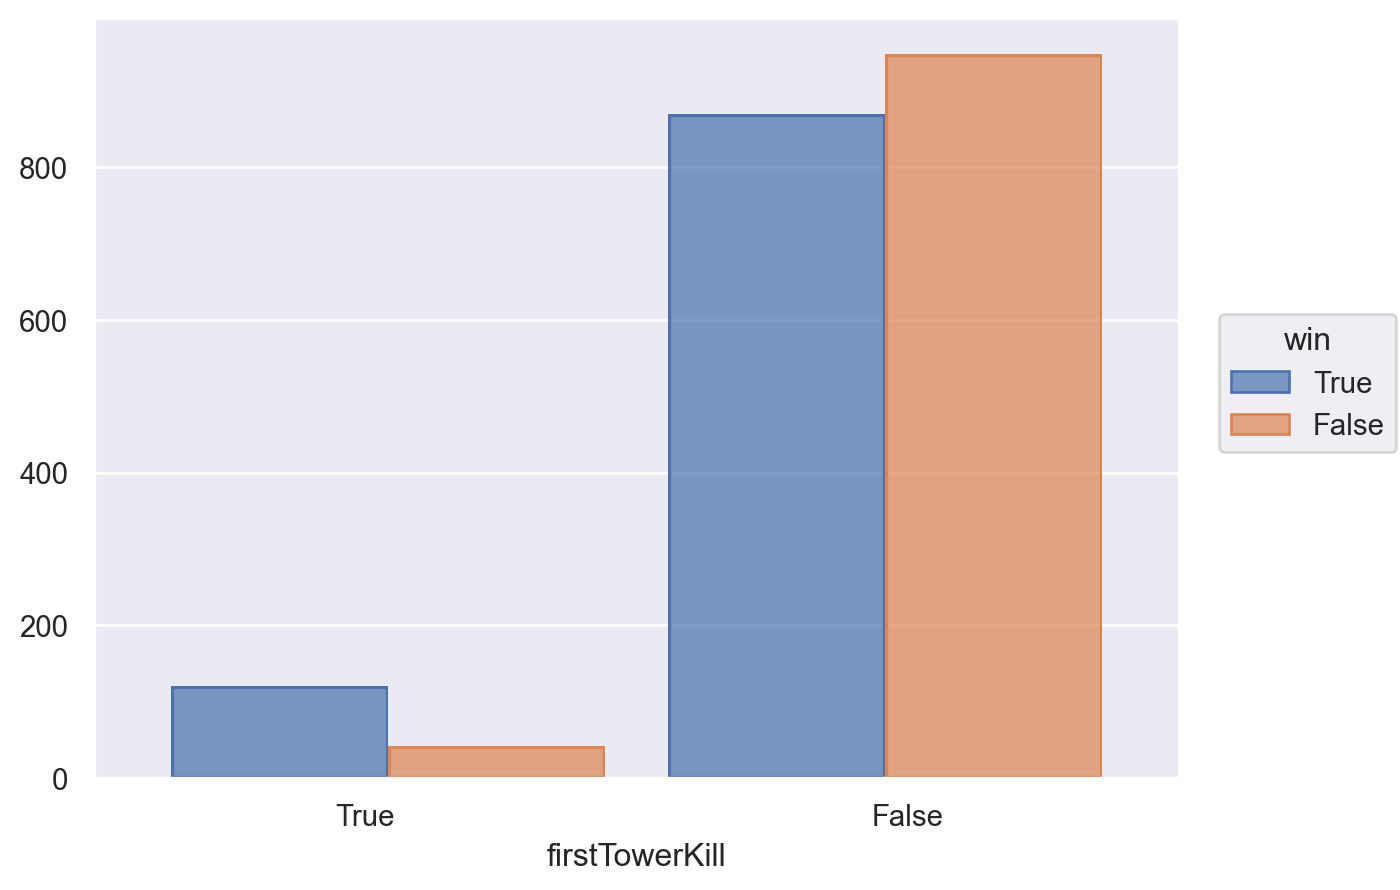

In [104]:
(
    so.Plot(df, x="firstTowerKill", color='win')
    .add(so.Bar(), so.Hist(), so.Dodge())
)

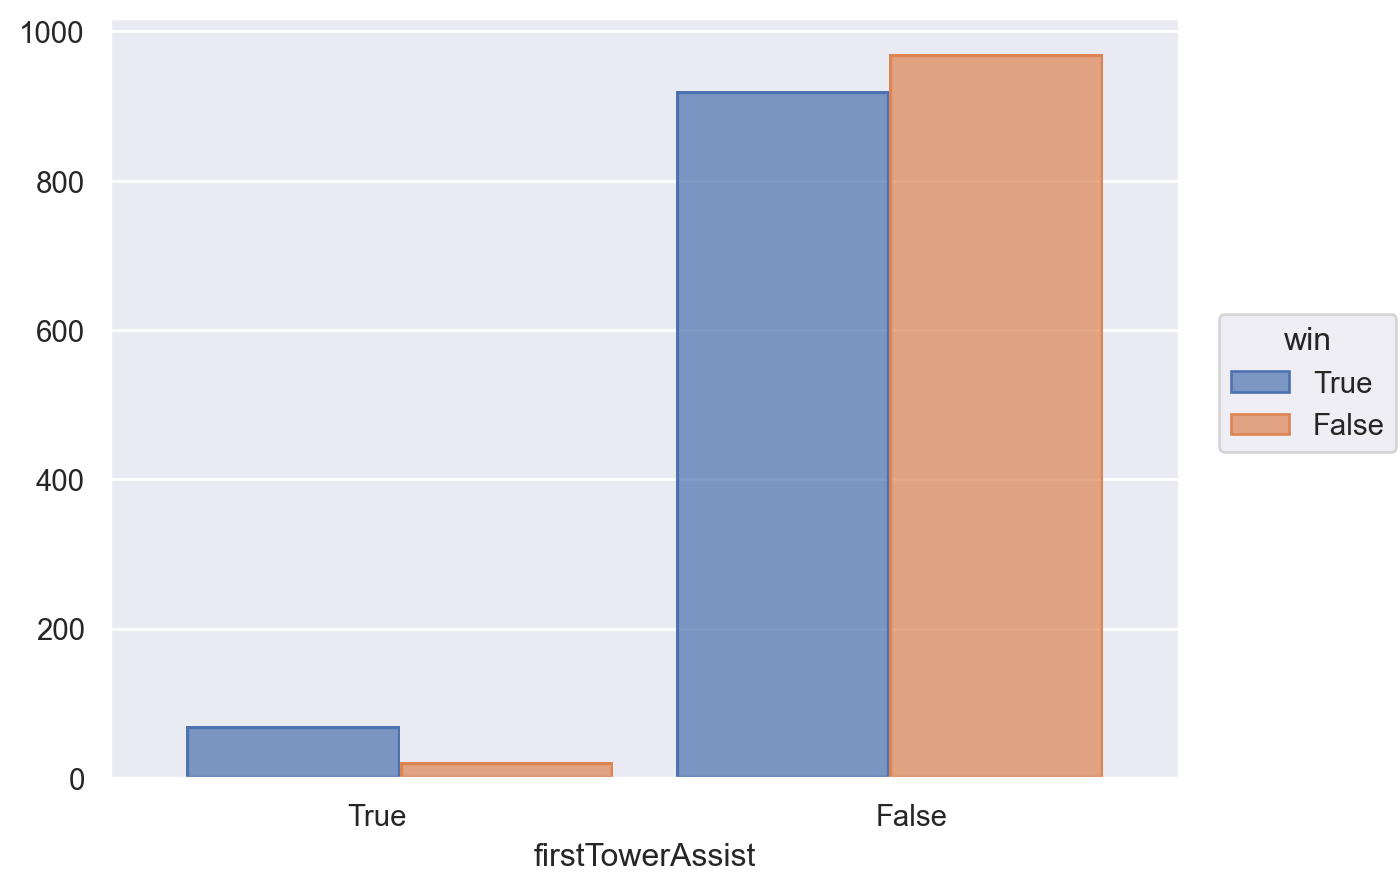

In [105]:
(
    so.Plot(df, x="firstTowerAssist", color='win')
    .add(so.Bar(), so.Hist(), so.Dodge())
)

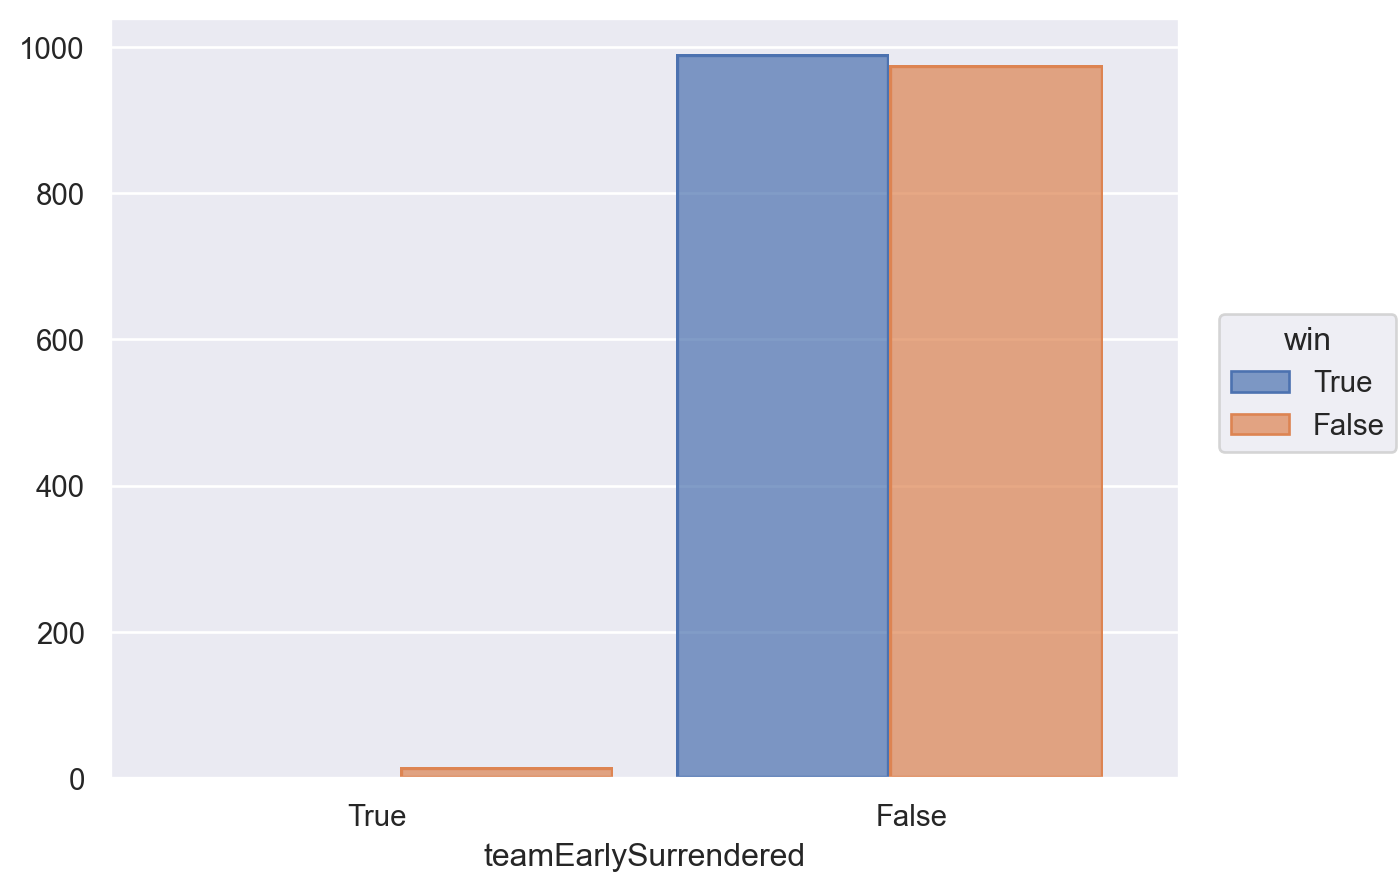

In [106]:
(
    so.Plot(df, x="teamEarlySurrendered", color='win')
    .add(so.Bar(), so.Hist(), so.Dodge())
)

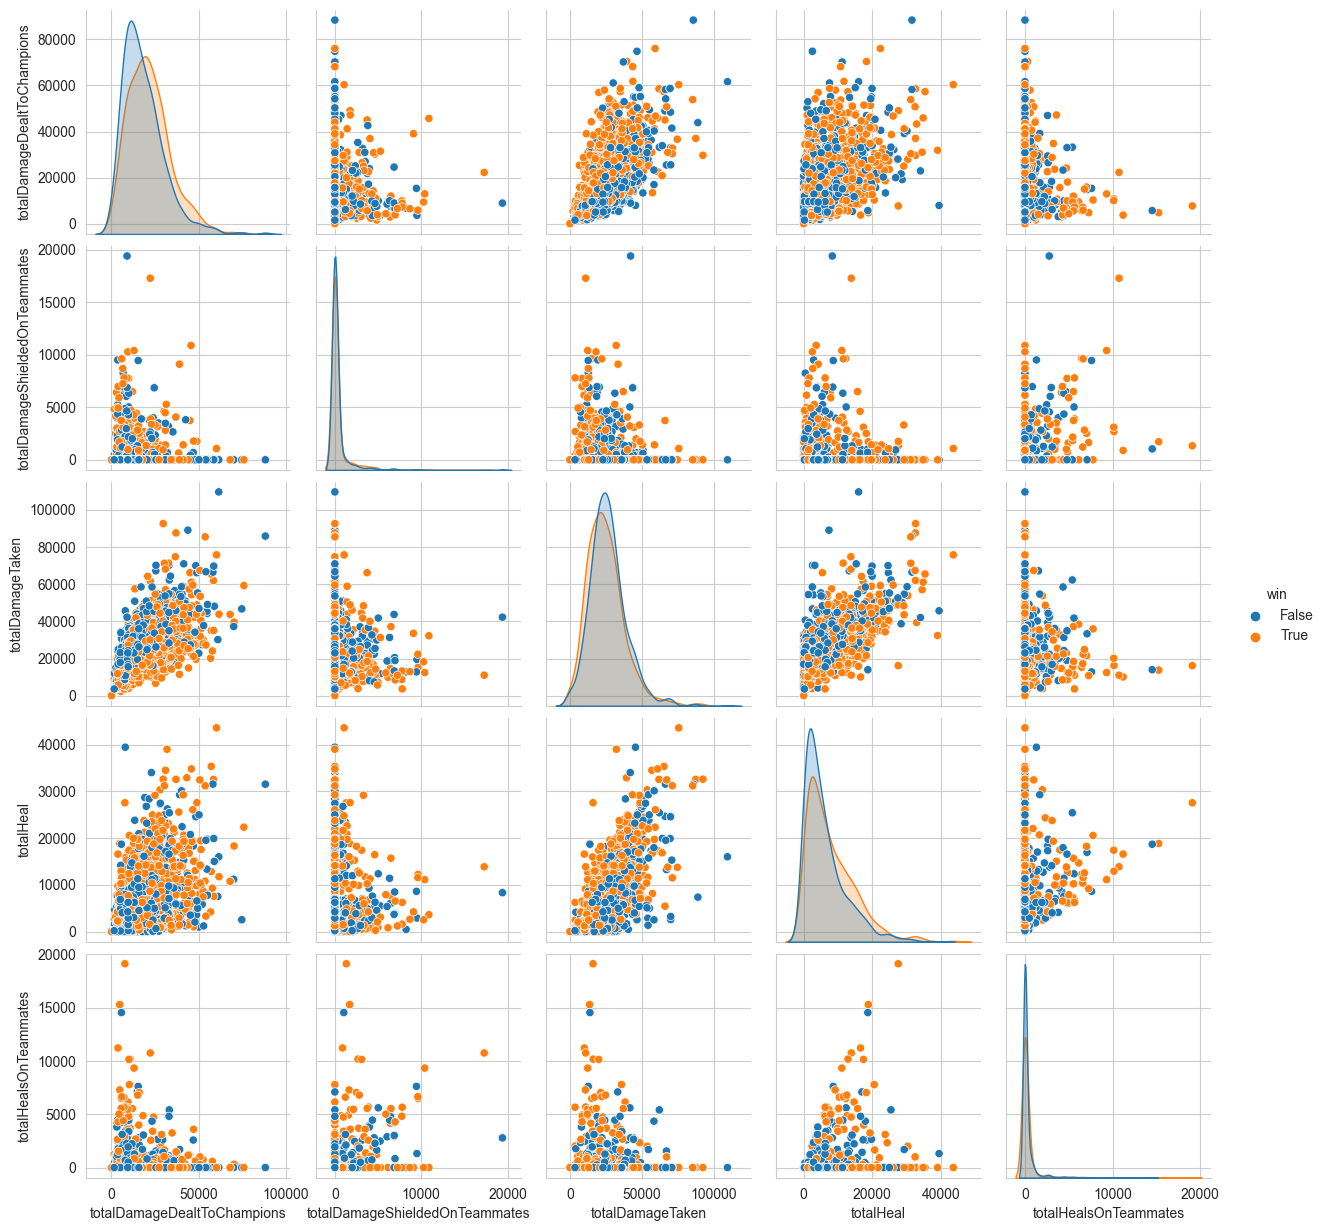

In [116]:
total_to_champ_df = df[['totalDamageDealtToChampions', 'totalDamageShieldedOnTeammates', 'totalDamageTaken', 'totalHeal', 'totalHealsOnTeammates', 'win']]

sns.pairplot(total_to_champ_df, hue="win", height=2.5)


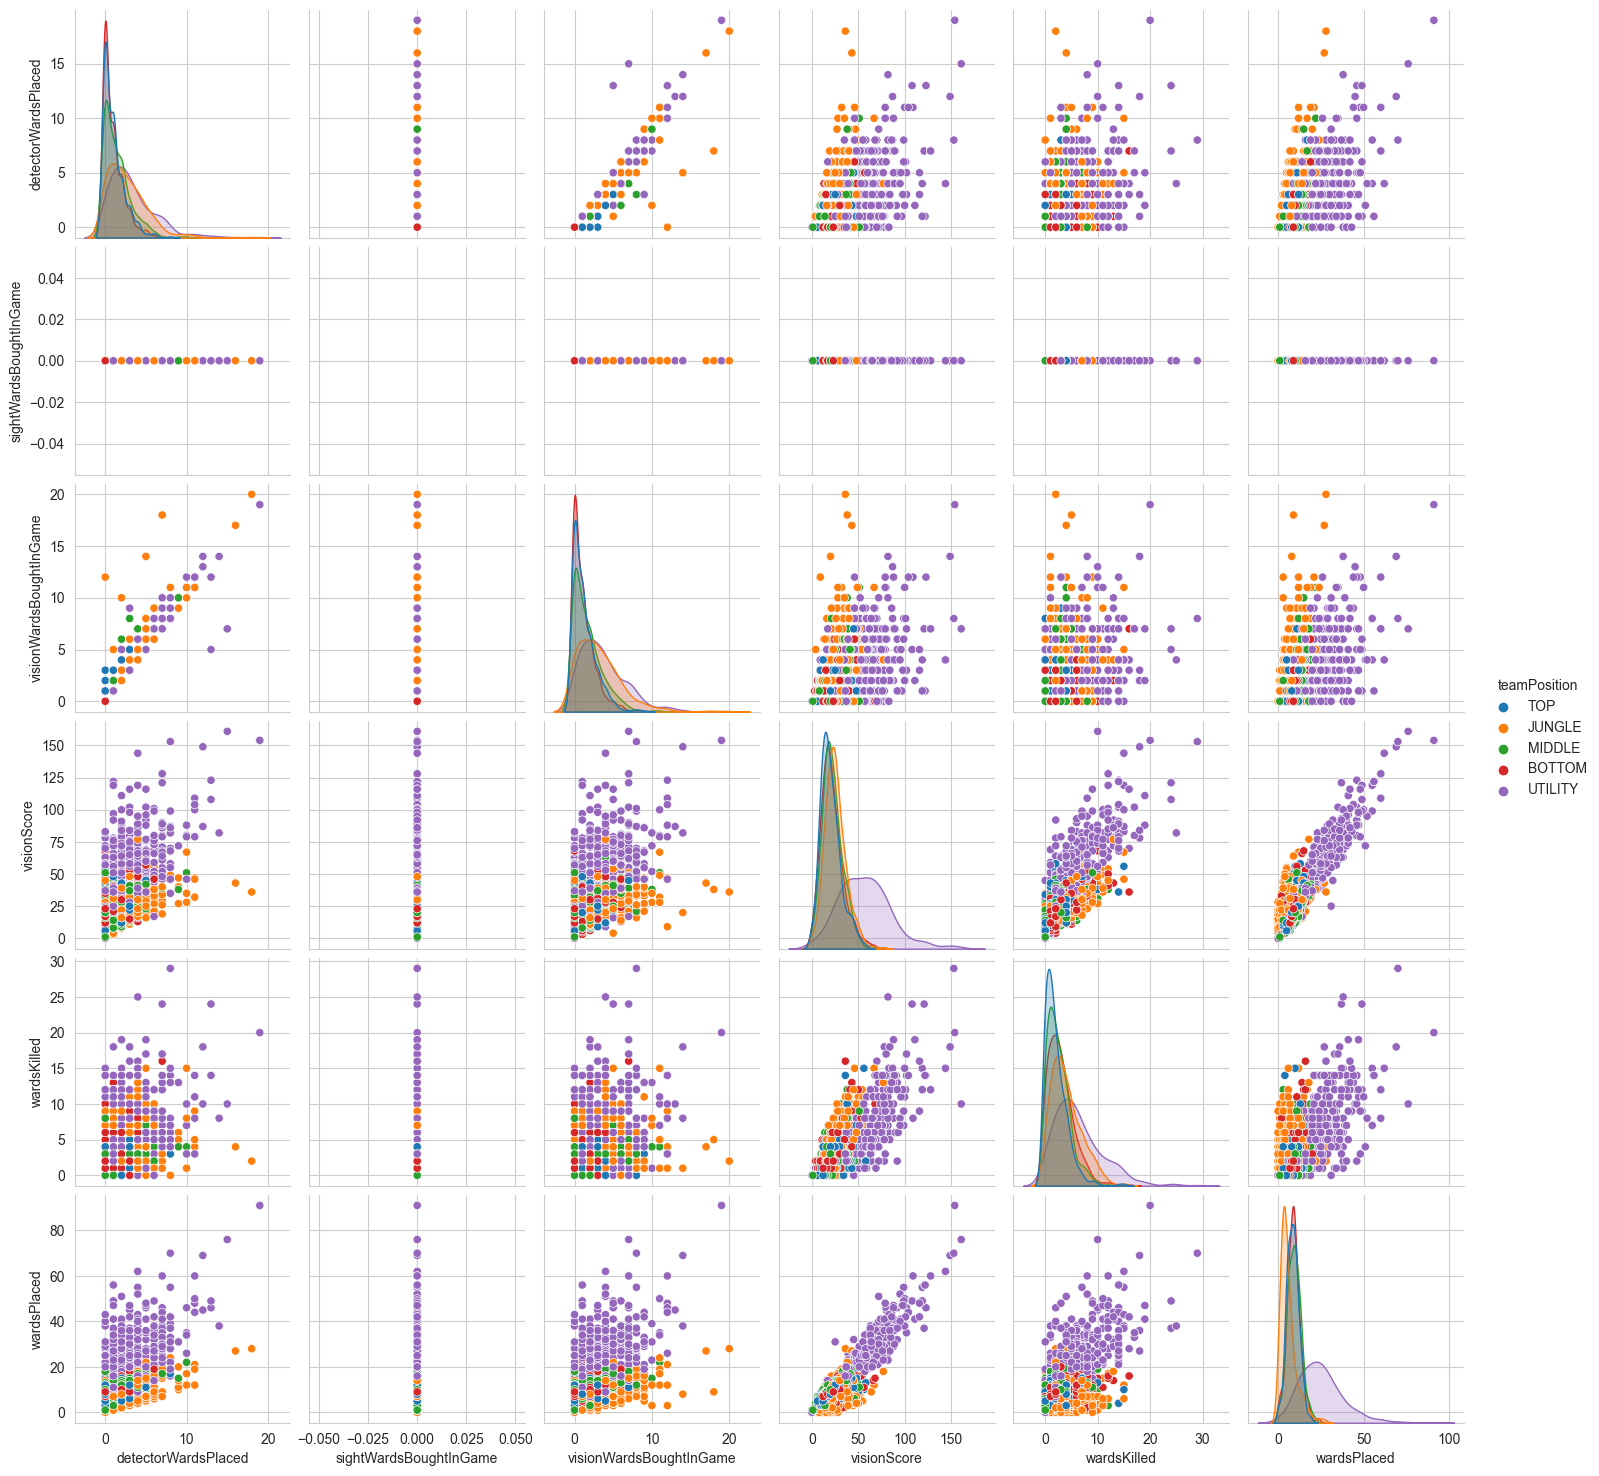

In [119]:
ward_vison_df = df[['detectorWardsPlaced', 'sightWardsBoughtInGame', 'visionWardsBoughtInGame', 'visionScore', 'wardsKilled', 'wardsPlaced', 'teamPosition']]

sns.pairplot(ward_vison_df, hue="teamPosition", height=2.5)